<a href="https://colab.research.google.com/github/itssofiarce/AA1-TUIA-Petetta-Arce/blob/main/TP_integrador_AA1_Petetta_Arce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
#from google.colab import drive
#drive.mount('/content/drive')

In [202]:
!pip3 install shap

In [203]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# De scikit-learn...

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# Estandarización y modelado
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_selector
# Division de los datos
from sklearn.model_selection import train_test_split

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Regresiones
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression

# ML metricas
from sklearn.metrics import mean_squared_error, r2_score, classification_report

In [204]:
path= '/content/weatherAUS.csv'
df = pd.read_csv(path, usecols=range(1,25))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [205]:
### Columnas
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [206]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,143928.000000,144159.000000,142152.000000,82658.000000,75616.000000,135159.000000,143645.000000,142351.000000,142759.000000,140907.000000,130351.000000,130388.000000,89542.000000,86076.000000,143646.000000,141805.000000,142153.000000
mean,12.195873,23.223176,2.361516,5.468616,7.611241,40.036564,14.044742,18.663164,68.877290,51.537432,1017.649277,1015.255184,4.447287,4.509770,16.992780,21.685249,2.361242
std,6.398018,7.118770,8.479338,4.193871,3.785612,13.607212,8.915610,8.810276,19.029576,20.796720,7.107132,7.037981,2.887161,2.720306,6.488045,6.936358,8.479084
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In [207]:
### Cantidad de valores faltantes.
df.isna().sum()

Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

In [208]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              145412 non-null  object 
 1   Location          145412 non-null  object 
 2   MinTemp           143928 non-null  float64
 3   MaxTemp           144159 non-null  float64
 4   Rainfall          142152 non-null  float64
 5   Evaporation       82658 non-null   float64
 6   Sunshine          75616 non-null   float64
 7   WindGustDir       135096 non-null  object 
 8   WindGustSpeed     135159 non-null  float64
 9   WindDir9am        134850 non-null  object 
 10  WindDir3pm        141186 non-null  object 
 11  WindSpeed9am      143645 non-null  float64
 12  WindSpeed3pm      142351 non-null  float64
 13  Humidity9am       142759 non-null  float64
 14  Humidity3pm       140907 non-null  float64
 15  Pressure9am       130351 non-null  float64
 16  Pressure3pm       13

In [209]:
df['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [210]:

costa_este = ["Adelaide", "Canberra", "Cobar", "Dartmoor", "Melbourne", "MelbourneAirport", "MountGambier", "Sydney", "SydneyAirport"]

df.loc[df['Location'].isin(costa_este), 'Location'] = 'costa_este'

df = df[df['Location'] == 'costa_este']

df = df.reset_index(drop=True)

In [211]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2009-01-01,costa_este,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
1,2009-01-02,costa_este,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
2,2009-01-03,costa_este,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
3,2009-01-04,costa_este,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
4,2009-01-05,costa_este,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0


In [212]:
### Busco duplicados
if not df.duplicated().any():
  print('No hay registros duplicados')

No hay registros duplicados


In [213]:
df.isnull().sum()

Date                   0
Location               0
MinTemp              570
MaxTemp              558
Rainfall             986
Evaporation         4353
Sunshine            6713
WindGustDir         1645
WindGustSpeed       1642
WindDir9am          1648
WindDir3pm           437
WindSpeed9am         358
WindSpeed3pm         340
Humidity9am          940
Humidity3pm          890
Pressure9am          839
Pressure3pm          829
Cloud9am            9367
Cloud3pm            9550
Temp9am              585
Temp3pm              576
RainToday            986
RainTomorrow         985
RainfallTomorrow     985
dtype: int64

In [214]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28233 entries, 0 to 28232
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              28233 non-null  object 
 1   Location          28233 non-null  object 
 2   MinTemp           27663 non-null  float64
 3   MaxTemp           27675 non-null  float64
 4   Rainfall          27247 non-null  float64
 5   Evaporation       23880 non-null  float64
 6   Sunshine          21520 non-null  float64
 7   WindGustDir       26588 non-null  object 
 8   WindGustSpeed     26591 non-null  float64
 9   WindDir9am        26585 non-null  object 
 10  WindDir3pm        27796 non-null  object 
 11  WindSpeed9am      27875 non-null  float64
 12  WindSpeed3pm      27893 non-null  float64
 13  Humidity9am       27293 non-null  float64
 14  Humidity3pm       27343 non-null  float64
 15  Pressure9am       27394 non-null  float64
 16  Pressure3pm       27404 non-null  float6

In [215]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,27663.000000,27675.000000,27247.000000,23880.000000,21520.000000,26591.000000,27875.000000,27893.000000,27293.000000,27343.000000,27394.000000,27404.000000,18866.000000,18683.000000,27648.000000,27657.000000,27248.000000
mean,11.263319,21.902078,2.050369,4.826499,6.891129,41.835471,15.130152,20.023052,68.766350,50.497385,1018.249325,1016.149624,4.668557,4.732805,15.477127,20.408345,2.049347
std,5.709936,6.693168,6.384560,3.707995,3.867622,14.186300,9.458606,8.979409,18.730306,19.944931,7.423776,7.267376,2.807571,2.628154,5.701031,6.532302,6.383931
min,-8.000000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,5.000000,1.000000,982.300000,984.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,7.400000,16.600000,0.000000,2.200000,3.800000,31.000000,9.000000,13.000000,57.000000,37.000000,1013.300000,1011.300000,1.000000,2.000000,11.400000,15.400000,0.000000
50%,10.900000,21.000000,0.000000,4.000000,7.400000,39.000000,13.000000,19.000000,70.000000,50.000000,1018.400000,1016.300000,6.000000,6.000000,15.000000,19.500000,0.000000
75%,15.200000,26.200000,1.000000,6.600000,10.000000,50.000000,20.000000,26.000000,83.000000,64.000000,1023.300000,1021.100000,7.000000,7.000000,19.125000,24.500000,1.000000
max,33.900000,46.800000,119.400000,86.200000,14.300000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,38.600000,46.100000,119.400000


In [216]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Unnamed: 0', 'Date', 'RainTomorrow'], axis=1)

In [217]:
class LocDropper(BaseEstimator, TransformerMixin):
#
#  costa_este = ["Adelaide", "Canberra", "Cobar", "Dartmoor", "Melbourne", "MelbourneAirport", "MountGambier", "Sydney", "SydneyAirport"]
#
#df.loc[df['Location'].isin(costa_este), 'Location'] = 'costa_este'
#
#df = df[df['Location'] == 'costa_este']
#
#df = df.reset_index(drop=True)


  def fit(self, X, y=None):
        return self

  def transform(self, X):
    aus_loc = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    return X[X['Location'].isin(aus_loc)]

In [218]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    aus_loc = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    return X[X['Location'].isin(aus_loc)]

In [219]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [220]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [221]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [222]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [223]:
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

In [224]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday']#,'RainTomorrow' ,'Canberra','Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [225]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X

In [226]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Date'], axis=1)

In [227]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    costa_este = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    X.loc[X['Location'].isin(costa_este), 'Location'] = 'costa_este'
    return X[X['Location'] == 'costa_este']

In [228]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [229]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [230]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [231]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [232]:
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

In [233]:
class BoolYNDropperEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X.dropna(subset=['RainToday'], inplace=True)
      X['RainTomorrow'] = X['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(float)
      X['RainToday'] = X['RainToday'].map({'No': 0, 'Yes': 1}).astype(float)

      return X

In [234]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday', 'RainTomorrow']#, ,'Canberra','Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [235]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X


In [236]:
class RLValDropper(BaseEstimator, TransformerMixin):
  def fit (self, X, y=None):
    return self
  def transform(self, X):
    X.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)
    return X


In [237]:
preprocessor = Pipeline([
     ('drop_null_val_rl', RLValDropper()),
     ('drop_not_needed_features', ColDropper()),
     ('drop_nor_needed_locations',LocDropper()),
     ('yes_no_dropper_encoder', BoolYNDropperEncoder()),
     ('fill_null_cat', CatFiller()),
     ('fill_num_cat', NumFiller()),
     ('encode_loc', LocEncoder()),
     ('encode_wind_dir', CoordRecat()),
     ('reset_index',ResetIndex()),
     ('treat_outliers',OutliersTreater()),
     ('standariza_values', Standarizer())
])


# Regresion logistica sin balancear

In [238]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1).copy()
y = df[['RainTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22586, 22), (5647, 22), (22586, 1), (5647, 1))

In [239]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainTomorrow'] = y['RainTomorrow']

In [240]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainTomorrow'] = y['RainTomorrow']

In [241]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [242]:
df_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp3pm,costa_este,WindGustDir_sin,WindGustDir_cos,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos,RainToday,RainTomorrow
0,1.932424,0.860553,-0.619293,2.100980,1.572176e+00,-0.032688,-0.671254,0.931877,-0.527252,0.480472,...,0.975456,0.0,1.797729,-0.041157,1.290036,0.735647,1.681124,0.111157,0.0,0.0
1,-0.902276,-1.098634,-0.619293,-1.334589,-1.022604e+00,-0.879158,-0.440638,-0.785023,1.037360,0.631364,...,-1.081484,0.0,0.215564,1.270808,0.782116,1.027231,0.752401,1.371036,0.0,0.0
2,-0.233216,0.257727,-0.619293,0.273550,2.648997e-16,-0.340495,-0.210021,-0.098263,-1.714199,-1.179342,...,0.264033,0.0,1.677295,0.460906,1.290036,0.735647,0.752401,1.371036,0.0,0.0
3,-0.743814,-1.279482,1.952340,-1.261491,2.648997e-16,-0.648303,-0.671254,-0.785023,0.875504,1.436123,...,-1.158812,0.0,-0.903200,-0.968860,-0.924033,0.735647,-1.213242,0.633011,1.0,1.0
4,1.192937,1.493522,-0.619293,2.027883,1.691476e+00,0.121215,1.058368,-0.556103,-0.743061,-1.179342,...,1.625016,0.0,1.677295,0.460906,1.629406,0.299247,1.240488,1.075431,0.0,0.0


In [243]:
train_clasificacion_X = df_train.iloc[:, :-1]
y_train_clasificacion = df_train.iloc[:,-1]

In [244]:
x_test_clasificacion = df_test.iloc[:, :-1]
y_test_clasificacion = df_test.iloc[:,-1]

In [245]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(train_clasificacion_X, y_train_clasificacion)
valor_y_predecir = classifier.predict(x_test_clasificacion)

#metricas

from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test_clasificacion, valor_y_predecir)
acc_score = accuracy_score(y_test_clasificacion, valor_y_predecir)

In [246]:
from sklearn.metrics import roc_curve, auc

In [247]:
probabilidades_y = classifier.predict_proba(x_test_clasificacion)[:,-1]
fpr, tpr, thresholds = roc_curve(y_test_clasificacion, probabilidades_y)
roc_auc = auc(fpr,tpr)

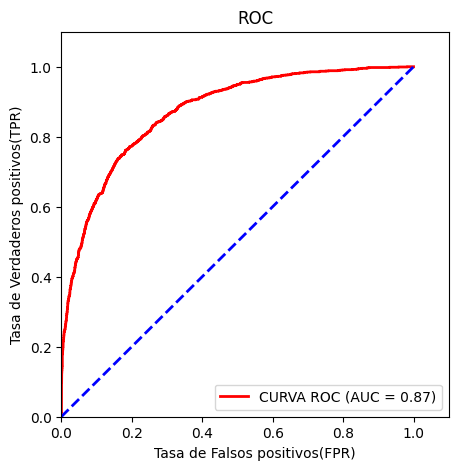

In [248]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color="red", lw=2, label='CURVA ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], color="blue", lw=2, linestyle="--")
plt.xlim([0.0, 1.10])
plt.ylim([0.0, 1.10])
plt.xlabel("Tasa de Falsos positivos(FPR)")
plt.ylabel("Tasa de Verdaderos positivos(TPR)")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

In [249]:
import shap
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import ConfusionMatrixDisplay

In [250]:
clasificacion_parametros = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': [None, 'l2'],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced']
}

optimizar_clasificacion = RandomizedSearchCV(
    LogisticRegression(random_state=23), clasificacion_parametros
)

optimizar_clasificacion.fit(train_clasificacion_X, y_train_clasificacion)
#para optimizar el balanceado hay que cambiar (((train_clasificacion_X, y_train_clasificacion)))
#por los correspondientes de smote

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

RandomizedSearchCV(estimator=LogisticRegression(random_state=23),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'class_weight': [None, 'balanced'],
                                        'max_iter': [100, 200, 300],
                                        'penalty': [None, 'l2'],
                                        'solver': ['liblinear', 'lbfgs',
                                                   'saga']})

In [251]:
modelo_optimizado_clasificacion = optimizar_clasificacion.best_estimator_

# metricas para datos NO balanceados

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90      4092
         1.0       0.73      0.51      0.60      1313

    accuracy                           0.83      5405
   macro avg       0.79      0.72      0.75      5405
weighted avg       0.83      0.83      0.82      5405



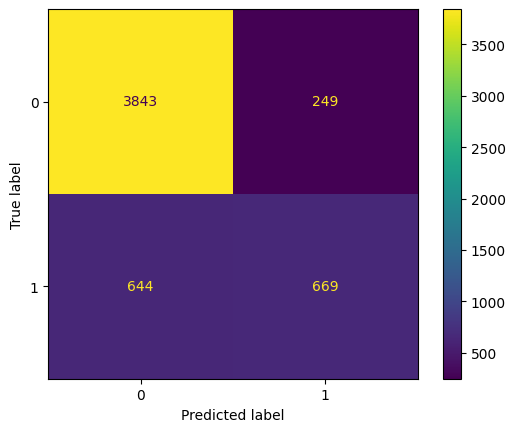

In [252]:
y_pred_clasificacion_optimizado = modelo_optimizado_clasificacion.predict(x_test_clasificacion)


print(classification_report(y_test_clasificacion, y_pred_clasificacion_optimizado))


ConfusionMatrixDisplay(
    confusion_matrix(y_test_clasificacion, y_pred_clasificacion_optimizado)
).plot()

# explicabilidad de modelo de regresion logistica sin balancear

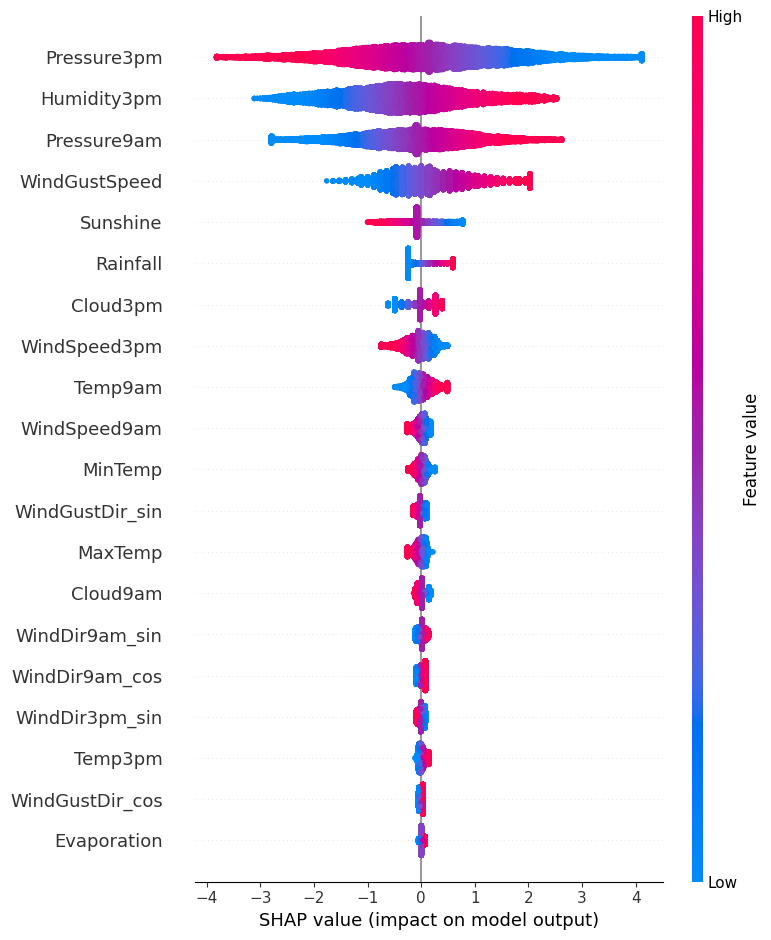

In [253]:
explicar_clasificacion = shap.LinearExplainer(
    classifier,
    train_clasificacion_X.astype("float64").copy(),
    features_names=train_clasificacion_X.columns,
)


shap_valores_clasificacion = explicar_clasificacion(
    train_clasificacion_X.astype("float64")
)

shap.summary_plot(shap_valores_clasificacion, train_clasificacion_X)

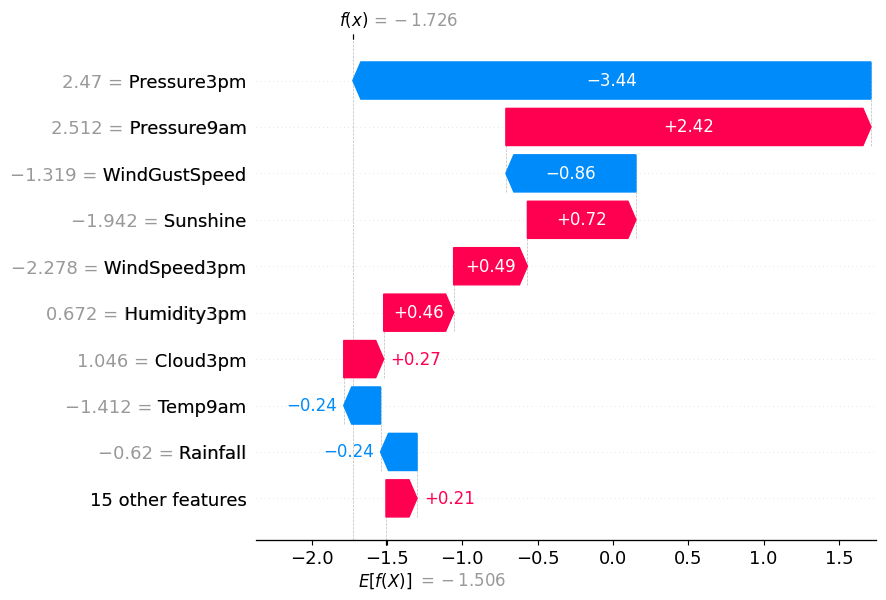

In [254]:
index = 50

classifier.predict(x_test_clasificacion)[index]

shap_valores_clasificacion = explicar_clasificacion(x_test_clasificacion)

explicacion = shap.Explanation(
    values=shap_valores_clasificacion[index],
    base_values=explicar_clasificacion.expected_value,
    feature_names=train_clasificacion_X.columns,
)


shap.plots.waterfall(explicacion)

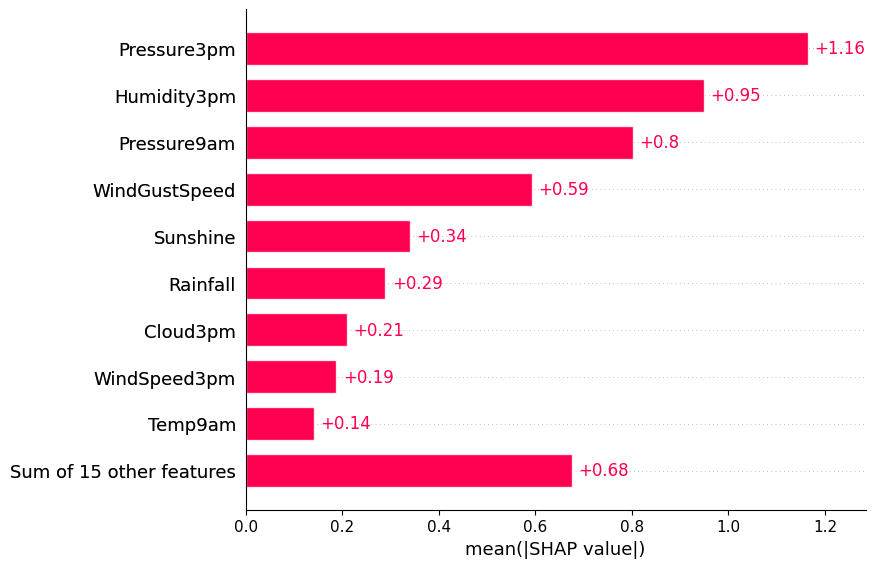

In [255]:
explicabilidad_global_clasificacion = shap.Explanation(
    shap_valores_clasificacion,
    base_values=explicar_clasificacion.expected_value,
    feature_names=train_clasificacion_X.columns,
    data=x_test_clasificacion,
)


shap.plots.bar(explicabilidad_global_clasificacion)

# modelo de regresion logistica balanceado

# Modelo base Regresion Lineal

In [256]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainfallTomorrow'], axis=1).copy()
y = df[['RainfallTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((22586, 23), (5647, 23), (22586, 1), (5647, 1))

In [257]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainfallTomorrow'] = y['RainfallTomorrow']

In [258]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainfallTomorrow'] = y['RainfallTomorrow']

In [259]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [260]:
X_base_regresion_train = df_train[['RainToday', 'Sunshine']]
Y_base_regresion_train = df_train["RainfallTomorrow"]

In [261]:
X_base_regresion_test = df_test[['RainToday', 'Sunshine',]]
Y_base_regresion_test = df_test["RainfallTomorrow"]

In [262]:
modelo_base_regresion = LinearRegression()

In [263]:
modelo_base_regresion.fit(X_base_regresion_train, Y_base_regresion_train)

LinearRegression()

In [264]:
y_pred_base_regresion = modelo_base_regresion.predict(X_base_regresion_test)

In [265]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from math import sqrt


In [266]:
def errores(y_test, y_pred):
    print("R2:   %.2f" % r2_score(y_test, y_pred))
    print("MSE:  %.2f" % mean_squared_error(y_test, y_pred))
    print("RMSE: %.2f" % sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE:  %.2f" % mean_absolute_error(y_test, y_pred))
    print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))


errores(Y_base_regresion_test, y_pred_base_regresion)

R2:   0.10
MSE:  0.90
RMSE: 0.95
MAE:  0.45
MAPE: 1.48


# Base clasificacion

In [267]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1).copy()
y = df[['RainTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22586, 22), (5647, 22), (22586, 1), (5647, 1))

In [268]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainTomorrow'] = y['RainTomorrow']

In [269]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainTomorrow'] = y['RainTomorrow']

In [270]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [271]:
#X_base_clasificacion_train = df_train[['RainToday', 'Sunshine', 'MinTemp']]
X_base_clasificacion_train = df_train[['MaxTemp', 'Sunshine', 'MinTemp']]
Y_base_clasificacion_train = df_train["RainTomorrow"]

In [272]:
#X_base_clasificacion_test = df_test[['RainToday', 'Sunshine', 'MinTemp']]
X_base_clasificacion_test = df_test[['MaxTemp', 'Sunshine', 'MinTemp']]
Y_base_clasificacion_test = df_test["RainTomorrow"]

In [273]:
modelo_base_clasificacion = LogisticRegression()

In [274]:
modelo_base_clasificacion.fit(X_base_clasificacion_train, Y_base_clasificacion_train)

LogisticRegression()

In [275]:
y_pred_base_clasificacion = modelo_base_clasificacion.predict(X_base_clasificacion_test)

In [276]:
from sklearn.metrics import ConfusionMatrixDisplay

Logistica Modelo base

              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86      4092
         1.0       0.59      0.27      0.37      1313

    accuracy                           0.78      5405
   macro avg       0.69      0.61      0.62      5405
weighted avg       0.75      0.78      0.74      5405



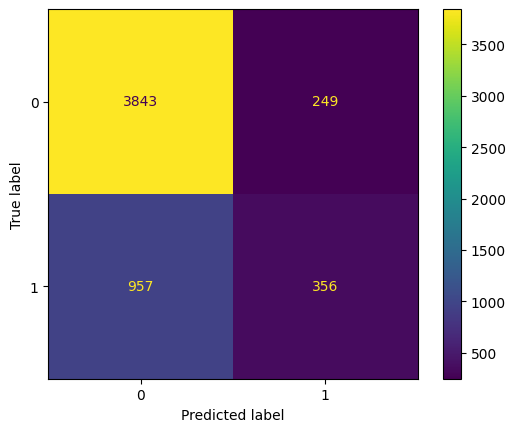

In [277]:
print("Logistica Modelo base\n")
print(classification_report(Y_base_clasificacion_test, y_pred_base_clasificacion))
ConfusionMatrixDisplay(confusion_matrix(Y_base_clasificacion_test, y_pred_base_clasificacion)).plot()
